In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

#Some code to beautify the plots
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

In [2]:
def lanczos(A, b, k, reorth = False):
    n = A.shape[0]
    V = np.zeros((n,k+1), dtype = 'd')
    
    
    alpha = np.zeros((k,), dtype = 'd')
    beta  = np.zeros((k+1,), dtype = 'd')
    
    beta[0] = np.linalg.norm(b)
    vjm1    = 0.

    v       = b/beta[0]
    V[:,0]  = np.copy(v)
    for j in range(k): 
        w = np.dot(A, v) -  beta[j]*vjm1
        vjm1 = np.copy(v)
        
        #Orthogonalize
        alpha[j] = np.inner(w,v)
        w = w - alpha[j]*v  
        
        if reorth:
            Vj = V[:,:j]
            w -= np.dot(Vj,np.dot(Vj.T,w))
        
        beta[j+1] = np.linalg.norm(w)
        v = w/beta[j+1]
        
        #Store current iterate
        V[:,j+1] = np.copy(v);
        
    
    return V, alpha, beta

### Run Lanczos algorithm on a test problem

Consider the tridiagonal matrix 

$$ A = \begin{bmatrix}2 & -1 \\ -1 & 2 & \ddots \\ &  \ddots & \ddots & -1 \\ & & -1 & 2 \end{bmatrix} .$$

In [11]:
n = 512
ones = np.ones((n,), dtype = 'd')
A = 2*np.diag(ones,0) - np.diag(ones[:-1], -1) - np.diag(ones[:-1], 1)
b = np.random.randn(n) 

### Assessing loss of orthogonality

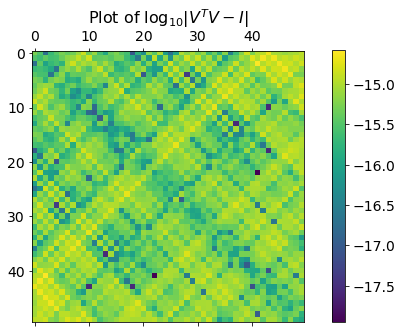

In [12]:
k = 50
V, alpha, beta = lanczos(A, b, k, reorth = False)
T = np.diag(alpha,0) + np.diag(beta[1:k],-1) + np.diag(beta[1:k],1)
plt.spy(T)


Vk = V[:,:k]
O = np.dot(Vk.T,Vk) - np.eye(k) + 1.e-16*np.ones((k,k), dtype = 'd')
plt.imshow(np.log10(np.abs(O ))); 
plt.title('Plot of $\log_{10}|V^T V -I|$', fontsize = 16)
plt.colorbar()

In [5]:
err = np.dot(Vk.T,np.dot(A,Vk)) - T
print("\| V' *A * V  - T\|_2 is ", np.linalg.norm(err,2))
err = np.dot(Vk.T,Vk) - np.eye(k)
print("\| V' * V  - I\|_2 is ", np.linalg.norm(err,2))
e = np.zeros((k,), dtype = 'd'); e[-1] = beta[-1];
err = np.dot(A,Vk) - np.dot(Vk,T) - np.outer(V[:,-1],e)
print("\|AV_k - V_kT_k - beta_{k}v_{k+1}e_k^T\|_2 is ", np.linalg.norm(err,2))

\| V' *A * V  - T\|_2 is  2.6599674824722838e-14
\| V' * V  - I\|_2 is  6.591061798344374e-15
\|AV_k - V_kT_k - beta_{k}v_{k+1}e_k^T\|_2 is  3.410903512150814e-16


## How good are the Ritz pairs?

Recall the Lanczos iteration 

$$A V_k = V_k T_k + \beta_k v_{k+1}e_k^\top. $$

Let $(\theta_j,y_j)$ denote the eigenvalues of T_k. The eigenvalues are known as the Ritz values. To get the approximate eigenvectors, we compute 

$$ z_j = V_k y_j \qquad j = 1,\dots,k. $$

Together, $(\theta_j,z_j)$ are knowns as the Ritz pairs. To assess the accuracy, we use the residuals


$$ \|r_j\|_2 = \|Az_j - \theta_j z_j\|_2 \qquad j=1,\dots,k.$$


### 1D Laplacian

Text(0.5, 1.0, 'Residuals')

<Figure size 720x360 with 0 Axes>

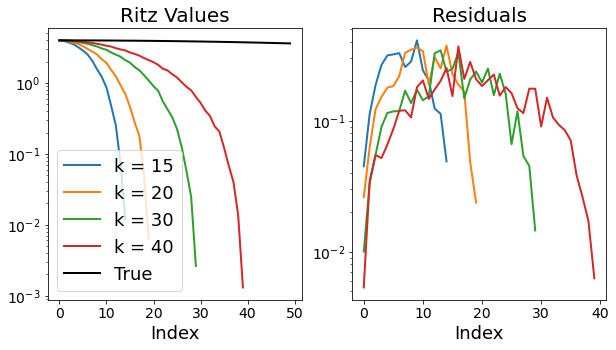

In [13]:
n = 250
ones = np.ones((n,), dtype = 'd')
A = 2*np.diag(ones,0) - np.diag(ones[:-1], -1) - np.diag(ones[:-1], 1)
b = np.random.randn(n) 

l, _ = np.linalg.eigh(A)
l = l[::-1]
f = plt.figure()

f, (ax1,ax2) = plt.subplots(1, 2, figsize = (10,5))

klst = [15,20,30, 40]
for i, k in enumerate(klst):
    
    V, alpha, beta = lanczos(A, b, k, reorth = True)
    T = np.diag(alpha,0) + np.diag(beta[1:k],-1) + np.diag(beta[1:k],1)
    
    lt, Y = np.linalg.eigh(T); lt = lt[::-1]; Y = Y[:,::-1]
    ax1.semilogy(range(k), lt, linewidth = 2.0)
    
    #Compute residuals
    rk = beta[-1]*np.abs(Y[-1,:])
    ax2.semilogy(range(k),rk.ravel(),linewidth = 2.0)
    
    
ax1.semilogy(range(50),l[:50], 'k-', linewidth = 2.0)

ax1.set_xlabel('Index', fontsize = 18)
leg =  ['k = ' + str(k) for k in klst]
leg.append( 'True')
ax1.set_title('Ritz Values', fontsize = 20)
ax1.legend(leg, fontsize = 18)

ax2.set_xlabel('Index', fontsize = 18)
ax2.set_title('Residuals', fontsize = 20)

### Using eigs

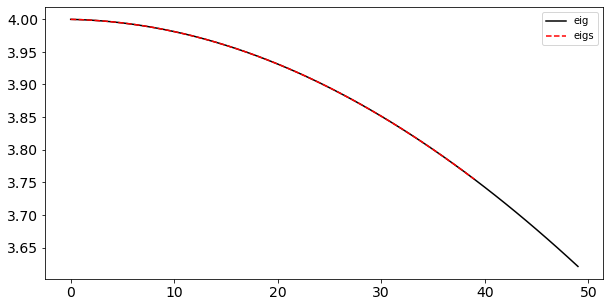

In [7]:
from scipy.sparse.linalg import eigs, eigsh
le, ve = eigsh(A, k = 40)

plt.plot(range(50),l[:50], 'k-', range(40), le[::-1], 'r--')
plt.legend(('eig', 'eigs'))

### Example 2: Decaying eigenvalues

Text(0.5, 1.0, 'Residuals')

<Figure size 720x360 with 0 Axes>

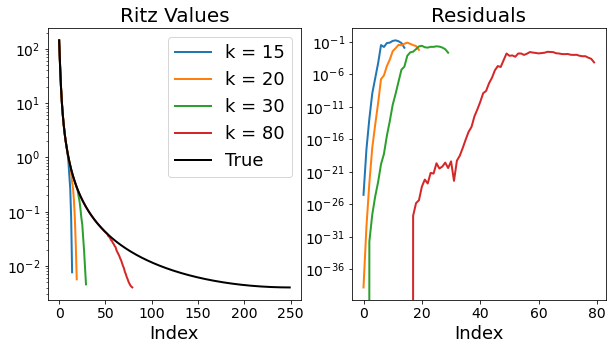

In [9]:
n = 250
x = np.linspace(0,1,n)
X,Y = np.meshgrid(x,x)

A = np.exp(-np.abs(X-Y)/0.5)
b = np.random.randn(n) 

l, _ = np.linalg.eigh(A)
l = l[::-1]
f = plt.figure()

f, (ax1,ax2) = plt.subplots(1, 2, figsize =  (10,5))

klst = [15,20,30, 80]
for i, k in enumerate(klst):
    
    V, alpha, beta = lanczos(A, b, k, reorth = True)
    T = np.diag(alpha,0) + np.diag(beta[1:k],-1) + np.diag(beta[1:k],1)
    
    lt, Y = np.linalg.eigh(T); lt = lt[::-1]; Y = Y[:,::-1]
    ax1.semilogy(range(k), lt, linewidth = 2.0)
    
    #Compute residuals
    rk = beta[-1]*np.abs(Y[-1,:])
    ax2.semilogy(range(k),rk.ravel(),linewidth = 2.0)
    
    
ax1.semilogy(range(l.size),l, 'k-', linewidth = 2.0)

ax1.set_xlabel('Index', fontsize = 18)
leg =  ['k = ' + str(k) for k in klst]
leg.append('True')
ax1.set_title('Ritz Values', fontsize = 20)
ax1.legend(leg, fontsize = 18)


ax2.set_xlabel('Index', fontsize = 18)
n = 250
x = np.linspace(0,1,n)
X,Y = np.meshgrid(x,x)

A = np.exp(-np.abs(X-Y)/0.5)
b = np.random.randn(n) 
ax2.set_title('Residuals', fontsize = 20)

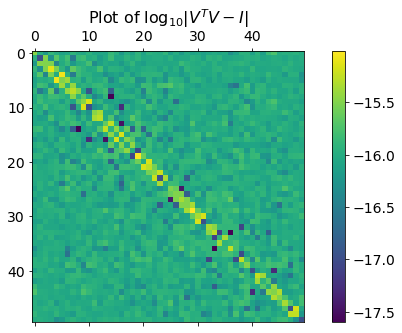

In [15]:
n = 250
x = np.linspace(0,1,n)
X,Y = np.meshgrid(x,x)

A = np.exp(-np.abs(X-Y)/0.5)
b = np.random.randn(n) 

k = 50
V, alpha, beta = lanczos(A, b, k, reorth = True)
T = np.diag(alpha,0) + np.diag(beta[1:k],-1) + np.diag(beta[1:k],1)
plt.spy(T)


Vk = V[:,:k]
O = np.dot(Vk.T,Vk) - np.eye(k) + 1.e-16*np.ones((k,k), dtype = 'd')
plt.imshow(np.log10(np.abs(O ))); 
plt.title('Plot of $\log_{10}|V^T V -I|$', fontsize = 16)
plt.colorbar()